In [2]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import datetime
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
import matplotlib.patches as mpatches
import scipy.io as sio
import matplotlib.colors as mcolors
import matplotlib.patches as patch
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from proj_utils import *
from mapping_utils import * 
fig_path      = '../figures'

In [3]:
sys.path.append('/home/jovyan/ECCOv4-py')
sys.path.append('/efs_ecco/ECCO/EMU/emu_userinterface_dir/')
import runpy
import emu_plot_arg_py as ept

In [4]:
bathy_path = user_home_dir + '/efs_ecco/ECCO/V4/r5/netcdf/latlon/geometry/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc'
ds_bathy   = xr.open_dataset(bathy_path).Depth

In [103]:
path_v    = '/efs_ecco/lenders/run_east_face///emu_adj_96_108_5_trxWa_east_face.bin_1/output/adxx_tauv.0000000129.data'

In [104]:
nx, ny = 90, 1170
adj_cmct  = np.fromfile(path_v,'>f4')
adj_cmct  = adj_cmct.reshape(-1,ny,nx)
adj_tiles = ecco.llc_compact_to_tiles(adj_cmct)

llc_compact_to_faces: dims, llc  (472, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (472, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


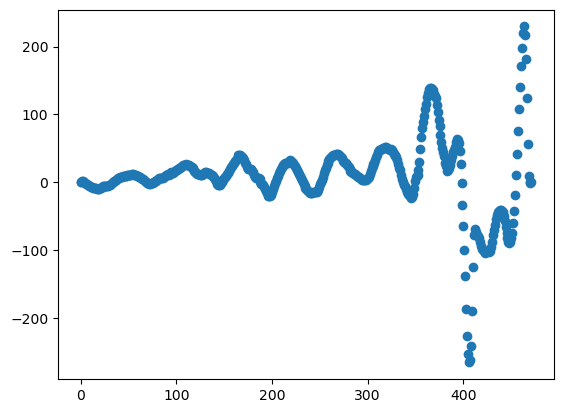

In [105]:
plt.scatter(np.arange(472),adj_tiles[:,10,35,75])

In [106]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

In [107]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True)
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')

In [108]:
mzz_local_file= mzz_local_directory / 'OCEAN_VELOCITY_mon_mean_native_llc090_ECCOV4r5.json' # Pull monthly velocity 
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [109]:
adj_tiles = np.flip(adj_tiles, axis=0)

In [72]:
# --- Time Dependent Velocity Across North Face ---\n",
for t in range((60)):
    # Interpolate Tiles to LatLong
    new_grid_lon_centers, new_grid_lat_centers,\
    new_grid_lon_edges, new_grid_lat_edges,\
    field_nearest_1deg =\
            ecco.resample_to_latlon(ds.XC, \
                                    ds.YC, \
                                    adj_tiles[t,:,:],\
                                    new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                    fill_value = np.nan, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)

    # Plot Sensitivity
    sv_name = '/tauv_ef_adj/tauv_ef_adj_sens_lag_lag_' + str(t).zfill(2)
    max_val = 3000
    plt_var = field_nearest_1deg
    plt_var[plt_var>max_val] = max_val
    plt_var[plt_var<-max_val] = -max_val
    bbox          = [-80,0,20,80] # Plotting Extent
    plot_this_box = [-80,0,0,60]    # Locator box indicating a region
    proj          = ccrs.PlateCarree() # Need to add this to most things as "transform=proj"
    fig,ax,_      = init_orthomap(1,1,bbox)
    
    ax     = add_coast_grid(ax,bbox,fill_color='k',line_color='k')
    levels = np.linspace(-3000,3000,61)
    
    colorplot = plt.contourf(new_grid_lon_centers,new_grid_lat_centers,field_nearest_1deg, levels=levels, cmap='cmo.balance', zorder=0,transform = proj)
    cbar = plt.colorbar(colorplot, fraction=0.057, pad=0.01, orientation='horizontal')
    plt.title('Lag = ' + str(t) + ' wks', fontsize = 16)
    plt.contour(ds_bathy.longitude,ds_bathy.latitude,ds_bathy,levels = [1000],colors='k',transform = proj)
    plt.savefig(fig_path  + sv_name + '.png', format='png', bbox_inches="tight",dpi=100)
    plt.close()

In [73]:
import glob
import contextlib
from PIL import Image
fp_in = fig_path + '/tauv_ef_adj/tauv_ef_adj_sens_lag_lag_*.png'
fp_out = fig_path + '/tauv_ef_adj_sens_lag_lag_.gif'

with contextlib.ExitStack() as stack:
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in))[::-1])
    img = next(imgs)
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [22]:
globals_dict = ept.emu_plot(run_name='/efs_ecco/lenders/run_north_face/emu_adj_96_108_5_trxWa_north_face.bin_1',
                            ctrl_num_list=[1, 2, 3, 4, 5, 6, 7, 8],
                            lag_beg=0, lag_end=1000000);

Found file: /efs_ecco/ECCO/EMU/emu_userinterface_dir/emu_env.singularity
EMU Input Files directory: /efs_ecco/ECCO/EMU2/emu_input_dir

Specified directory of EMU run to examine: /efs_ecco/lenders/run_north_face/emu_adj_96_108_5_trxWa_north_face.bin_1

Reading /efs_ecco/lenders/run_north_face/emu_adj_96_108_5_trxWa_north_face.bin_1

Reading Adjoint Tool output ... 

Found file: adxx_empmr.0000000129.data

*********************************************
Read adjoint gradient for empmr
   adxx: adjoint gradient as a function of space and lag
from file /efs_ecco/lenders/run_north_face/emu_adj_96_108_5_trxWa_north_face.bin_1/output/adxx_empmr.0000000129.data
 
Zero lag at (week/record) = 471
Max  lag at (week/record) = 1
Specified start and end files #: 0 and 1000000

*********************************************
Outputting adxx_empmr

Found file: adxx_pload.0000000129.data

*********************************************
Read adjoint gradient for pload
   adxx: adjoint gradient as a function o

In [29]:
import plot_adj
return_vars_dict = globals_dict.get('return_vars')
adj2d_all = return_vars_dict['adxx_tauv']
fname = return_vars_dict['adxx_tauv_filename']
pinfo = 'lag, rec = 3, 24 adxx_tauv.0000000129.data'
lag0 = return_vars_dict['adxx_tauv_lag0']
lagmax = return_vars_dict['adxx_tauv_lagmax']
nlag = lag0-lagmax+1
ww = np.arange(nlag)
ftitle = f'(i,j,lon,lat)= {42:2},{255:4}  {3.3:7.1f} {64.9:6.1f} {fname}'

In [30]:
help(plot_adj.plot_adj_vs_lag)

Help on function plot_adj_vs_lag in module plot_adj:

plot_adj_vs_lag(ww, adxx_vs_lag, ftitle)
    # Plot gradients vs. time lag



In [110]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
    ecco.resample_to_latlon(ds.XC, \
                            ds.YC, \
                            adj_tiles[0,:,:],\
                            new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                            new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                            fill_value = np.nan, \
                            mapping_method = 'nearest_neighbor',
                            radius_of_influence = 120000)
field_nearest_1deg_start = np.expand_dims(field_nearest_1deg, axis=0)
for t in range(1,472):
    # Interpolate Tiles to LatLong
    new_grid_lon_centers, new_grid_lat_centers,\
    new_grid_lon_edges, new_grid_lat_edges,\
    field_nearest_1deg_temp =\
            ecco.resample_to_latlon(ds.XC, \
                                    ds.YC, \
                                    adj_tiles[t,:,:],\
                                    new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                    fill_value = np.nan, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
    field_nearest_1deg_temp = np.expand_dims(field_nearest_1deg_temp, axis=0)
    field_nearest_1deg_start = np.vstack((field_nearest_1deg_start,field_nearest_1deg_temp))

In [111]:
field_nearest_1deg_start.shape

(472, 180, 360)

In [119]:
time = np.arange(472)

In [134]:
field_nearest_1deg_start = field_nearest_1deg_start[::-1]

In [137]:
time = np.arange(472)
time

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [140]:
plt_var.shape

(472, 80)

In [172]:
xticks = (np.arange(0,472,50))
xlabs = [str(element) for element in xticks]

In [173]:
xticks

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450])

Text(0.5, 1.0, 'Lat = 35˚N, tauu NF')

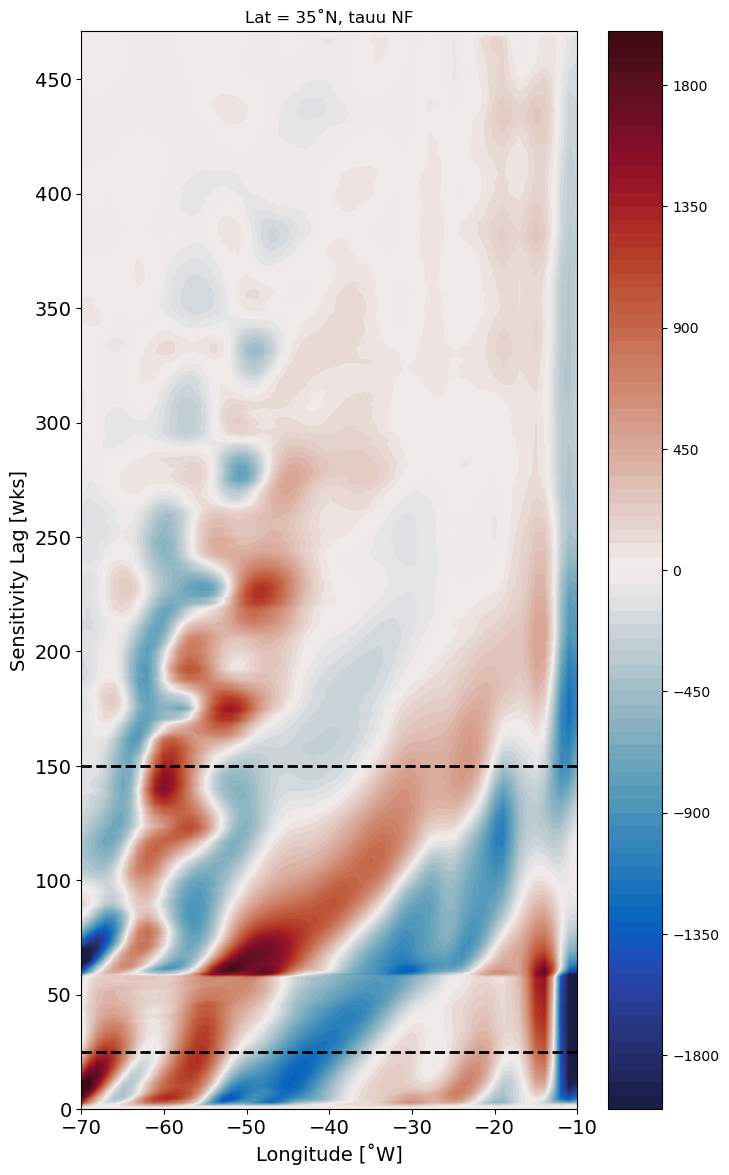

In [180]:
vmax = 2000
plt_var = field_nearest_1deg_start[:,125,100:180]
plt_var[plt_var>2000] = 2000
plt_var[plt_var<-2000] = -2000

levels = np.arange(-2000,2050,50)
plt.figure(figsize=(8, 14))
plt.contourf(new_grid_lon_edges[0,100:180],time,plt_var,levels=levels,cmap = 'cmo.balance')
plt.colorbar()
plt.axhline(25,color='k',linewidth=2,linestyle = '--')
plt.axhline(150,color='k',linewidth=2,linestyle = '--')
plt.xlim(-70,-10)
plt.yticks(np.arange(0,472,50),labels=xlabs,fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Sensitivity Lag [wks]',fontsize = 14)
plt.xlabel('Longitude [˚W]',fontsize=14)
plt.title('Lat = 35˚N, tauu NF')

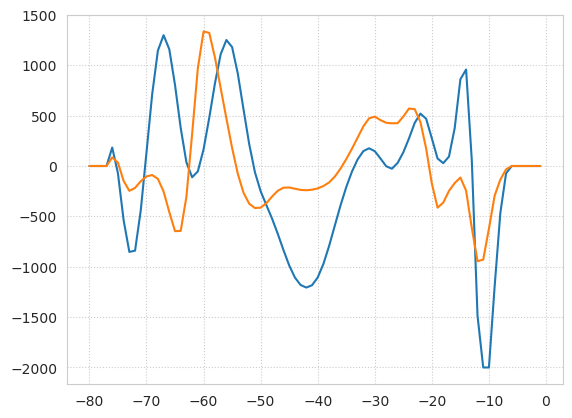

In [184]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.plot(new_grid_lon_edges[0,100:180],field_nearest_1deg_start[25,125,100:180])
plt.plot(new_grid_lon_edges[0,100:180],field_nearest_1deg_start[150,125,100:180])

Text(0.5, 1.0, 'Lat = 35˚N, tauu NF')

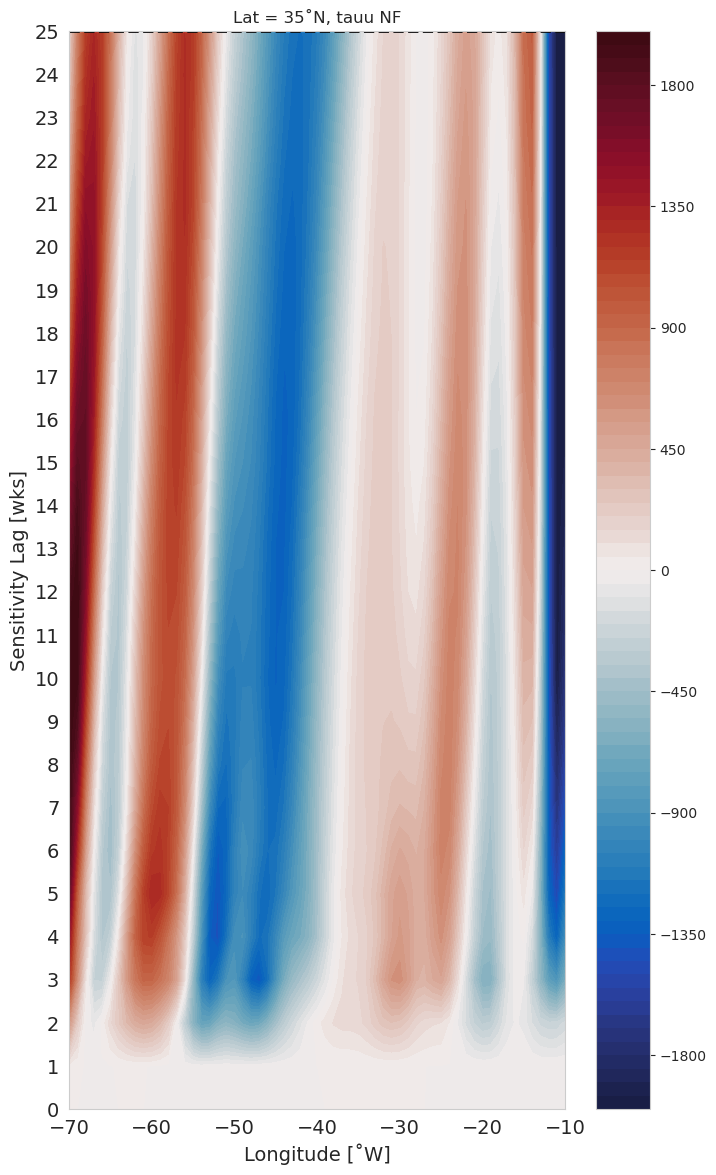

In [191]:
vmax = 2000
plt_var = field_nearest_1deg_start[:,125,100:180]
plt_var[plt_var>2000] = 2000
plt_var[plt_var<-2000] = -2000

levels = np.arange(-2000,2050,50)
plt.figure(figsize=(8, 14))
plt.contourf(new_grid_lon_edges[0,100:180],time,plt_var,levels=levels,cmap = 'cmo.balance')
plt.colorbar()
plt.axhline(25,color='k',linewidth=2,linestyle = '--')
plt.axhline(150,color='k',linewidth=2,linestyle = '--')
plt.xlim(-70,-10)
plt.yticks(np.arange(0,26),labels=[str(element) for element in np.arange(0,26)],fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylim(0,25)
plt.ylabel('Sensitivity Lag [wks]',fontsize = 14)
plt.xlabel('Longitude [˚W]',fontsize=14)
plt.title('Lat = 35˚N, tauu NF')

In [ ]:
60 Lon * (250*7)

In [90]:
new_grid_lat_centers[125,0]

np.float64(35.5)

In [ ]:
plt.figure(figsize=(8, 14))
levels = np.linspace(-0.25,0.25,51)
plt.contourf(sla_ds.longitude,sla_ds.time,np.squeeze(sla_ds.sel(latitude = slice(34.9,35)).sla.data),levels = levels,cmap ='RdBu')
plt.colorbar()
plt.axvline(305)